# Notebook Dedicated to Construct the Antinu plots of Observables using the Analyzed Gold  and Bronze Data and Compare with MC models

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import glob
import re
import itertools
import pickle

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load dictionaries of Real Data with Antinu Finder Results

In [26]:
str(20*1e6/1e6)

'20.0'

In [39]:
#Primary cuts:
dcFlag_cut = 0x2100000042C2
nhits_cut = 20

#Define the cut values used to construct the dictionaries to select the data.pkl to read --------------------------------------
en_cut_inf = 1.6
en_cut_sup = 8.0
posr_cut_sup = 5500
runID_cut = 300700

#Vetoing HS and atmospheric :
nhits_hs_number = 1500  #nhits above this value is an hotspot suspected
nhits_atm_number = 3000 #nhits above this value is an atmospheric suspected
dt_hs_remove = 1e6  # Remove 1s of data after a hs
dt_atm_remove = 20*1e6  # Remove 20s of data after an atmospheric


#Antinufinder cuts
alpha = 9
tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5 # (0.5) -> To avoid retriggers

dr_sup_lim = 1000 
dr_inf_lim = 0

energy_delay_sup_cut = 2.3
energy_delay_inf_cut = 1.9
# ------------------------------------------------------------------------------------------------------------------------------

# Define the directories where the dictonaries were saved and pattern filename
antinu_dict_bronze_dir = 'C:/Users/joanc/jupyter notebooks/Antineutrino Analysis/Real Data Analysis/bronze analysis/antinu_dict/vetoing plus runID cut/'
antinu_dict_gold_dir = 'C:/Users/joanc/jupyter notebooks/Antineutrino Analysis/Real Data Analysis/gold analysis/antinu_dict/vetoing plus runID cut/'

#Read Analysis and AnalysisR dictionaries
fname = f'antinu*_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

#Create lists with the bronze and gold dictionaries
antinu_bronze_flist = glob.glob(antinu_dict_bronze_dir + fname +'.pkl')
antinu_gold_flist = glob.glob(antinu_dict_gold_dir + fname +'.pkl')

#Concatenate list of bronze and gold data
flist = list(itertools.chain(antinu_bronze_flist, antinu_gold_flist))

#data to extract:
energy_prompt_real_data = np.array([])
energy_delay_real_data = np.array([])
delta_t_real_data = np.array([])
delta_r_real_data = np.array([])
hs_counts = np.array([])
atm_counts = np.array([])

# Load data and save observables
for i_dx, file_i in enumerate(flist):
    with open(file_i, 'rb') as f:
        #locals()['antinu_dict_' + str(i_dx)] = pickle.load(f)
        antinu_dict_i = pickle.load(f)

    energy_prompt_real_data = np.append(energy_prompt_real_data, antinu_dict_i['energy_prompt'])
    energy_delay_real_data = np.append(energy_delay_real_data, antinu_dict_i['energy_delay'])
    delta_t_real_data = np.append(delta_t_real_data, antinu_dict_i['delta_t'])
    delta_r_real_data = np.append(delta_r_real_data, antinu_dict_i['delta_r'])
    hs_counts = np.append(hs_counts, antinu_dict_i['hs_counter'])
    atm_counts = np.append(atm_counts, antinu_dict_i['atm_counter'])

hs_total_counts = np.sum(hs_counts)
atm_total_counts = np.sum(atm_counts)

In [71]:
energy_prompt_real_data.shape

(86,)

In [16]:
hs_total_counts

121105.0

In [17]:
atm_total_counts

468.0

# Load MC Data

## Reactor $\bar{\nu}$

In [28]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/reactor_nu/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt_reactor_nu = observable_dict['energy_prompt']
energy_delay_reactor_nu = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt_reactor_nu = observable_dict['dt']
dr_reactor_nu = observable_dict['dr']

energy_prompt_sup_cut = 8.0
#energy_delay_inf_cut = 1.8
#energy_delay_sup_cut = 3.5
#dt_sup_lim = 2000
#dt_inf_lim = 0
#dr_sup_lim = 1000.0

energy_condition = (energy_prompt_reactor_nu <= energy_prompt_sup_cut) & (energy_delay_reactor_nu >= energy_delay_inf_cut) & (energy_delay_reactor_nu <= energy_delay_sup_cut)
dt_condition = (dt_reactor_nu > dt_inf_lim) & (dt_reactor_nu <= dt_sup_lim)
dr_condition = (dr_reactor_nu >= dr_inf_lim) & (dr_reactor_nu <= dr_sup_lim)

cut_condition = energy_condition & dt_condition & dr_condition

energy_prompt_reactor_nu = energy_prompt_reactor_nu[cut_condition]
energy_delay_reactor_nu = energy_delay_reactor_nu[cut_condition]
dt_reactor_nu = dt_reactor_nu[cut_condition]
dr_reactor_nu = dr_reactor_nu[cut_condition]

reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_12\
saving 

## Geo $\nu$ U-238/235

In [6]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/geo_nu_U/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt_geo_nu_U = observable_dict['energy_prompt']
energy_delay_geo_nu_U = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt_geo_nu_U = observable_dict['dt']
dr_geo_nu_U = observable_dict['dr']

energy_prompt_sup_cut = 8.0
#energy_delay_inf_cut = 1.8
#energy_delay_sup_cut = 3.5
#dt_sup_lim = 2000
#dt_inf_lim = 0
#dr_sup_lim = 1000.0

energy_condition = (energy_prompt_geo_nu_U <= energy_prompt_sup_cut) & (energy_delay_geo_nu_U >= energy_delay_inf_cut) & (energy_delay_geo_nu_U <= energy_delay_sup_cut)
dt_condition = (dt_geo_nu_U > dt_inf_lim) & (dt_geo_nu_U <= dt_sup_lim)
dr_condition = (dr_geo_nu_U >= dr_inf_lim) & (dr_geo_nu_U <= dr_sup_lim)

cut_condition = energy_condition & dt_condition & dr_condition

energy_prompt_geo_nu_U = energy_prompt_geo_nu_U[cut_condition]
energy_delay_geo_nu_U = energy_delay_geo_nu_U[cut_condition]
dt_geo_nu_U = dt_geo_nu_U[cut_condition]
dr_geo_nu_U = dr_geo_nu_U[cut_condition]

reading folder E:/Data/antinu/mc/geo_nu_U/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_U/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_U/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_U/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_U/out_results\output_12\
saving informatio

## Geo $\nu$ Th-232

In [7]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/geo_nu_Th/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt_geo_nu_Th = observable_dict['energy_prompt']
energy_delay_geo_nu_Th = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt_geo_nu_Th = observable_dict['dt']
dr_geo_nu_Th = observable_dict['dr']

energy_prompt_sup_cut = 8.0
#energy_delay_inf_cut = 1.8
#energy_delay_sup_cut = 3.5
#dt_sup_lim = 2000
#dt_inf_lim = 0
#dr_sup_lim = 1000.0

energy_condition = (energy_prompt_geo_nu_Th <= energy_prompt_sup_cut) & (energy_delay_geo_nu_Th >= energy_delay_inf_cut) & (energy_delay_geo_nu_Th <= energy_delay_sup_cut)
dt_condition = (dt_geo_nu_Th > dt_inf_lim) & (dt_geo_nu_Th <= dt_sup_lim)
dr_condition = (dr_geo_nu_Th >= dr_inf_lim) & (dr_geo_nu_Th <= dr_sup_lim)

cut_condition = energy_condition & dt_condition & dr_condition

energy_prompt_geo_nu_Th = energy_prompt_geo_nu_Th[cut_condition]
energy_delay_geo_nu_Th = energy_delay_geo_nu_Th[cut_condition]
dt_geo_nu_Th = dt_geo_nu_Th[cut_condition]
dr_geo_nu_Th = dr_geo_nu_Th[cut_condition]

reading folder E:/Data/antinu/mc/geo_nu_Th/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_Th/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_Th/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_Th/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/geo_nu_Th/out_results\output_12\
saving infor

## $\alpha$-n

In [8]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/alpha_n/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt_alpha_n = observable_dict['energy_prompt']
energy_delay_alpha_n = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt_alpha_n = observable_dict['dt']
dr_alpha_n = observable_dict['dr']

energy_prompt_sup_cut = 8.0

energy_condition = (energy_prompt_alpha_n <= energy_prompt_sup_cut) & (energy_delay_alpha_n >= energy_delay_inf_cut) & (energy_delay_alpha_n <= energy_delay_sup_cut)
dt_condition = (dt_alpha_n > dt_inf_lim) & (dt_alpha_n <= dt_sup_lim)
dr_condition = (dr_alpha_n >= dr_inf_lim) & (dr_alpha_n <= dr_sup_lim)

cut_condition = energy_condition & dt_condition & dr_condition

energy_prompt_alpha_n = energy_prompt_alpha_n[cut_condition]
energy_delay_alpha_n = energy_delay_alpha_n[cut_condition]
dt_alpha_n = dt_alpha_n[cut_condition]
dr_alpha_n = dr_alpha_n[cut_condition]

reading folder E:/Data/antinu/mc/alpha_n/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/alpha_n/out_results\output_12\
saving information of 

In [9]:
max(dr_alpha_n)

999.9994127784734

## BiPo-214

In [9]:
#Main Data Directory
main_dir = 'E:/Data/antinu/mc/bipo214/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt_bipo214 = observable_dict['energy_prompt']
energy_delay_bipo214 = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt_bipo214 = observable_dict['dt']
dr_bipo214 = observable_dict['dr']

energy_prompt_sup_cut = 8.0

energy_condition = (energy_prompt_bipo214 <= energy_prompt_sup_cut) & (energy_delay_bipo214 >= energy_delay_inf_cut) & (energy_delay_bipo214 <= energy_delay_sup_cut)
dt_condition = (dt_bipo214 > dt_inf_lim) & (dt_bipo214 <= dt_sup_lim)
dr_condition = (dr_bipo214 >= dr_inf_lim) & (dr_bipo214 <= dr_sup_lim)

cut_condition = energy_condition & dt_condition & dr_condition

energy_prompt_bipo214 = energy_prompt_bipo214[cut_condition]
energy_delay_bipo214 = energy_delay_bipo214[cut_condition]
dt_bipo214 = dt_bipo214[cut_condition]
dr_bipo214 = dr_bipo214[cut_condition]

reading folder E:/Data/antinu/mc/bipo214/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/bipo214/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/bipo214/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/bipo214/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/bipo214/out_results\output_12\
saving information of 

# Plots

### Main Title settings

In [68]:
main_title = 'Bronze + Gold Data - '

dcFlag_cut_title = f'mask = {hex(dcFlag_cut)}, '
nhits_cut_title = rf'nHits $\geq$ {nhits_cut}, '
energy_cut_title = f'E: [{en_cut_inf}, {en_cut_sup}] (MeV), '
posr_cut_title = rf'R $\leq$ {posr_cut_sup} (mm), '
runID_cut_title = rf'runID > {runID_cut}'

general_cuts_title = dcFlag_cut_title + nhits_cut_title + energy_cut_title + posr_cut_title + runID_cut_title
antinufinder_title = rf'Antinu-Finder Cuts: $\Delta$t: [{dt_inf_lim}, {dt_sup_lim}] ($\mu$s), $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm), Energy_delay: [{energy_delay_inf_cut}, {energy_delay_sup_cut}] (MeV)'
vetoing_title = rf'Vetoing Cuts: nhits_hotspots $\geq$ {nhits_hs_number} and remove {dt_hs_remove/(1e6)}s of data - nhits_atmospherics $\geq$ {nhits_atm_number} and remove {dt_atm_remove/(1e6)}s of data'

### Save figs settings

In [72]:
save_dir = 'figs/'
main_title_save = f'Bronze_plus_Gold_antinu_dict_vetoing_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

### Energy Plots

#### 1st plot only the energy data to adjust the correct binwidth

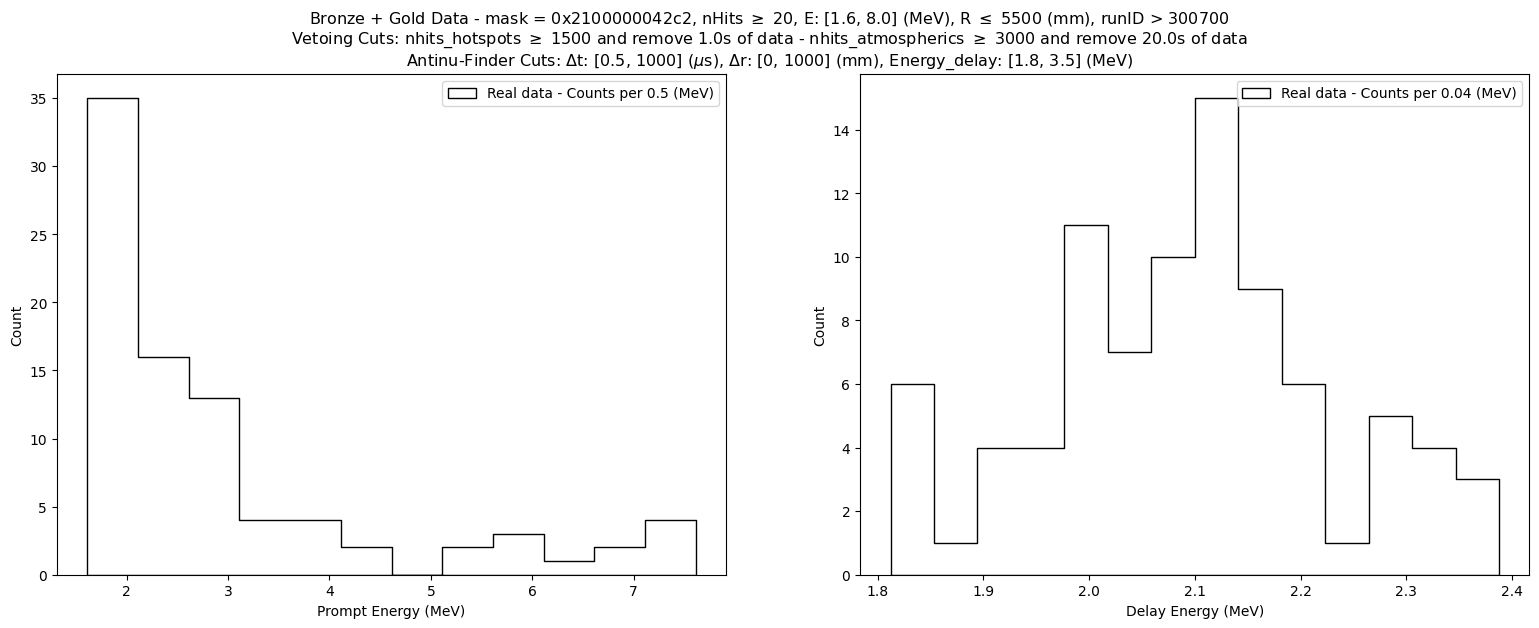

In [90]:
binwidth_prompt = 0.5
binwidth_delay = 0.04

fig, axes = plt.subplots(1, 2,  figsize=(19, 6.5))

sn.histplot(energy_prompt_real_data, ax = axes[0], binwidth = binwidth_prompt, color = 'black', element = 'step', alpha = 0, label = f'Real data - Counts per {binwidth_prompt} (MeV)')
sn.histplot(energy_delay_real_data, ax = axes[1], binwidth = binwidth_delay, color = 'black', element = 'step', alpha = 0, label = f'Real data - Counts per {binwidth_delay} (MeV)')
#sn.histplot(energy_delay_bipo214, ax = axes[1], bins = binsd_bipo214, stat = 'density', color = 'green', element = 'poly', alpha = 0, label = 'BiPo-214')

axes[0].set_xlabel('Prompt Energy (MeV)')
#axes[0].set_ylabel(f'Counts per {binwidth_prompt} (MeV)')
axes[0].legend(loc = 'upper right', fontsize = 10)
#axes[0].set_yscale('log')

axes[1].set_xlabel('Delay Energy (MeV)')
#axes[1].set_ylabel(f'Counts per {binwidth_delay} (MeV)')
axes[1].legend(loc = 'upper right', fontsize = 10)
#axes[1].set_yscale('log')

plt.suptitle(main_title + general_cuts_title  + '\n' + vetoing_title + '\n' + antinufinder_title, fontsize = 11.5)
#plt.savefig(save_dir + 'prompt and delay energy/energy_' + main_title_save+'.png', format = 'png', bbox_inches = 'tight')

plt.show()

KeyboardInterrupt: 

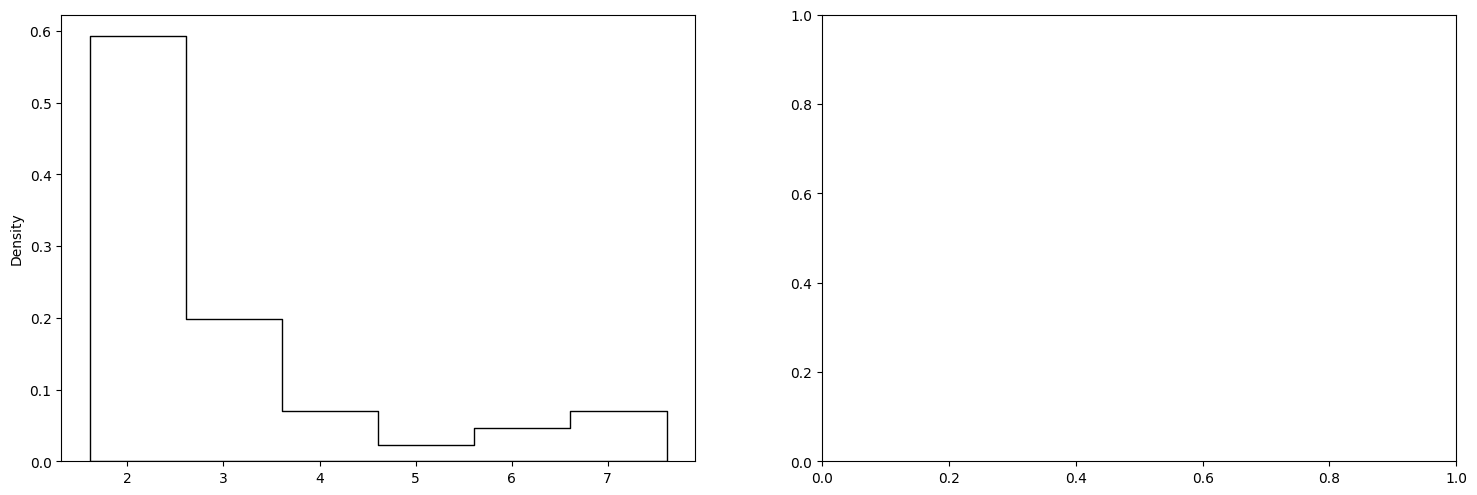

In [11]:
#binwidth_prompt = 0.9
binsp_reactor_nu = 50
binsp_geo_nuU = 32
binsp_geo_nuTh = 40
binsp_alpha_n = 50
binsp_bipo214 = 30

#binwidth_delay = 0.15
binsd_reactor_nu = 30
binsd_geo_nuU = 40
binsd_geo_nuTh = 50
binsd_alpha_n = 30
binsd_bipo214 = 25

fig, axes = plt.subplots(1, 2,  figsize=(19, 6.5))

sn.histplot(energy_prompt_real_data, ax = axes[0], binwidth = binwidth_prompt, stat = 'density', color = 'black', element = 'step', alpha = 0, label = f'Real data - Density per {binwidth_prompt} (MeV)')
sn.histplot(energy_prompt_reactor_nu, ax = axes[0], bins = binsp_reactor_nu, stat = 'density', color = red_variants[0], element = 'poly', alpha = 0, label = r'Reactor $\bar{\nu}$ MC')
sn.histplot(energy_prompt_geo_nu_U, ax = axes[0], bins = binsp_geo_nuU, stat = 'density', color = red_variants[1], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from U-238/235 MC')
sn.histplot(energy_prompt_geo_nu_Th, ax = axes[0], bins = binsp_geo_nuTh, stat = 'density', color = red_variants[2], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from Th-232 MC')
sn.histplot(energy_prompt_alpha_n, ax = axes[0], bins = binsp_alpha_n, stat = 'density', color = 'blue', element = 'poly', alpha = 0, label = r'C-13 $\alpha$-n MC')
sn.histplot(energy_prompt_bipo214, ax = axes[0], bins = binsp_bipo214, stat = 'density', color = 'green', element = 'poly', alpha = 0, label = 'BiPo-214 MC')

sn.histplot(energy_delay_real_data, ax = axes[1], binwidth = binwidth_delay, stat = 'density', color = 'black', element = 'step', alpha = 0, label = f'Real data - Density per {binwidth_delay} (MeV)')
sn.histplot(energy_delay_reactor_nu, ax = axes[1], bins = binsd_reactor_nu, stat = 'density', color = red_variants[0], element = 'poly', alpha = 0, label = r'Reactor $\bar{\nu}$ MC')
sn.histplot(energy_delay_geo_nu_U, ax = axes[1], bins = binsd_geo_nuU, stat = 'density', color = red_variants[1], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from U-238/235 MC')
sn.histplot(energy_delay_geo_nu_Th, ax = axes[1], bins = binsd_geo_nuTh, stat = 'density', color = red_variants[2], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from Th-232 MC')
sn.histplot(energy_delay_alpha_n, ax = axes[1], bins = binsd_alpha_n, stat = 'density', color = 'blue', element = 'poly', alpha = 0, label = r'C-13 $\alpha$-n MC')
#sn.histplot(energy_delay_bipo214, ax = axes[1], bins = binsd_bipo214, stat = 'density', color = 'green', element = 'poly', alpha = 0, label = 'BiPo-214')

axes[0].set_xlabel('Prompt Energy (MeV)')
#axes[0].set_ylabel(f'Counts per {binwidth_prompt} (MeV)')
axes[0].legend(loc = 'upper right', fontsize = 8.5)
axes[0].set_yscale('log')
#axes[0].set_xlim(min(energy_prompt_real_data), max(energy_prompt_real_data))

axes[1].set_xlabel('Delay Energy (MeV)')
#axes[1].set_ylabel(f'Counts per {binwidth_delay} (MeV)')
axes[1].legend(loc = 'upper right', fontsize = 10)
#axes[1].set_yscale('log')
#axes[1].set_xlim(min(energy_delay_real_data), max(energy_delay_real_data))

plt.suptitle(main_title + general_cuts_title  + '\n' + vetoing_title + '\n' + antinufinder_title, fontsize = 11.5)
plt.savefig(save_dir + 'prompt and delay energy/energy_' + main_title_save+'.png', format = 'png', bbox_inches = 'tight')

plt.show()

### $\Delta$t and $\Delta$r plots

#### 1st plot only the Dt and Dr data to adjust the correct binwidth

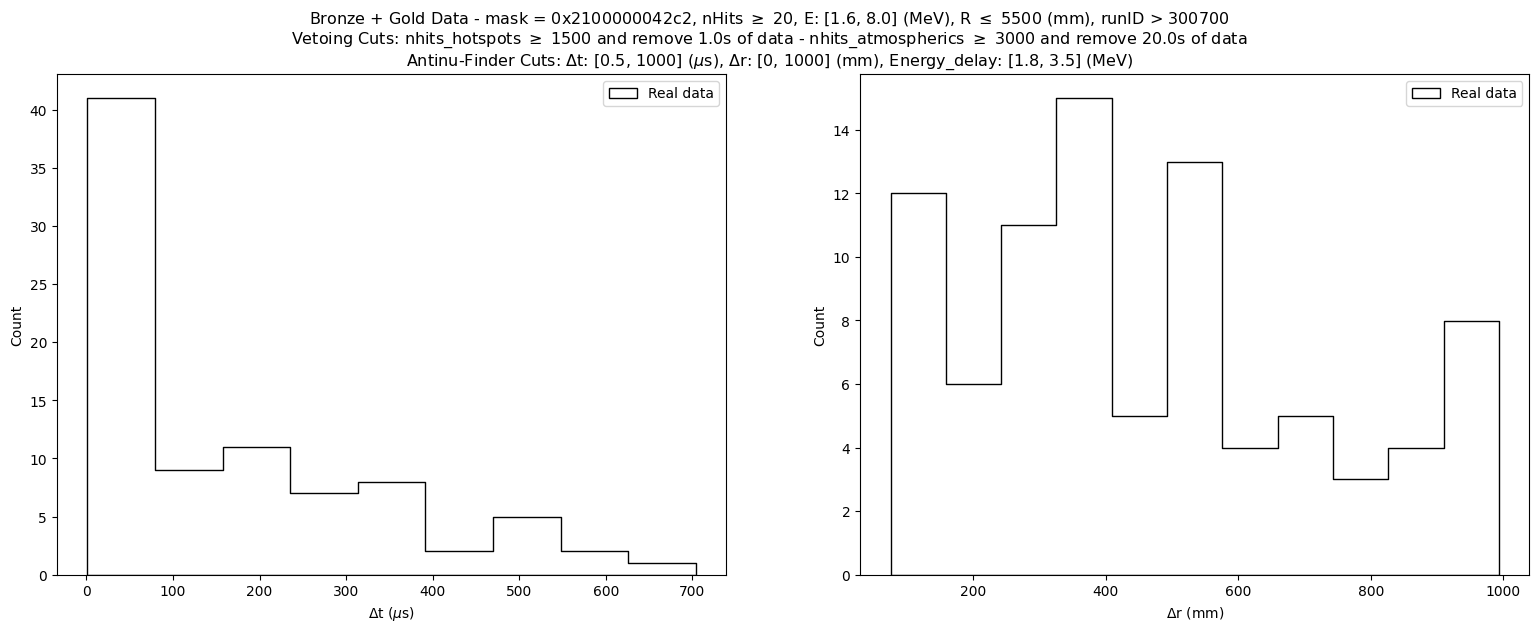

In [83]:
binwidth_dt = 80
binwidth_dr = 80

fig, axes = plt.subplots(1, 2,  figsize=(19, 6.5))

sn.histplot(delta_t_real_data, ax = axes[0], binwidth = binwidth_dt, color = 'black', element = 'step', alpha = 0, label = 'Real data')


sn.histplot(delta_r_real_data, ax = axes[1], binwidth = binwidth_dr, color = 'black', element = 'step', alpha = 0, label = 'Real data')


axes[0].set_xlabel(r'$\Delta$t ($\mu$s)', fontsize = 10)
axes[0].legend(loc = 'upper right')
#axes[0].set_ylabel(rf'Candidate Count per {binwidth_dt} ($\mu$s)', fontsize = 11)

axes[1].set_xlabel(r'$\Delta$r (mm)', fontsize = 10)
axes[1].legend(loc = 'upper right')
#axes[1].set_ylabel(f'Candidate Count per {binwidth_dr} (mm)', fontsize = 11)

#plt.suptitle(main_title + general_cuts_title  + '\n' + vetoing_title + '\n' + antinufinder_title, fontsize = 11.5)

plt.savefig(save_dir + 'Dt and Dr/delta_r_delta_r_' + main_title_save +'.png', format = 'png', bbox_inches = 'tight')
plt.show()

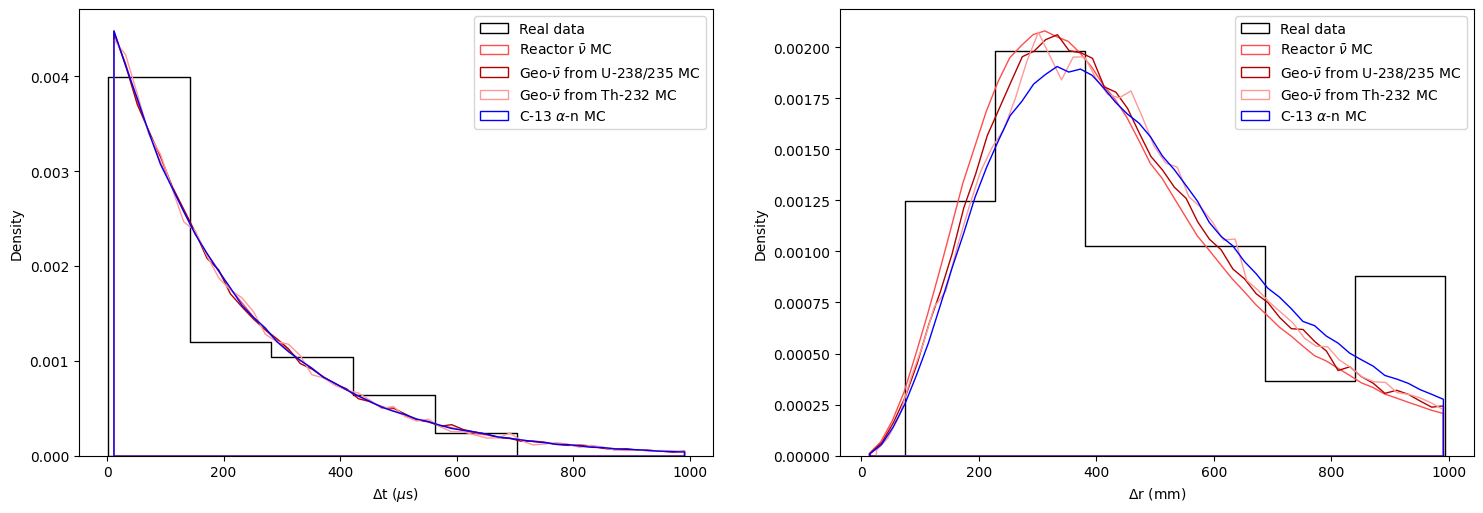

In [22]:
#binwidth_dt = 100
bins_reactornu_dt = 50
bins_geonuU_dt = 50
bins_geonuTh_dt = 50
bins_alpha_n_dt = 50
bins_bipo214_dt = 30

#binwidth_dr = 70
bins_reactor_nu_dr = 50
bins_geonuU_dr = 50
bins_geonuTh_dr = 50
bins_alpha_n_dr = 50
bins_bipo214_dr = 50

fig, axes = plt.subplots(1, 2,  figsize=(19, 6.5))

sn.histplot(delta_t_real_data, ax = axes[0], binwidth = binwidth_dt, stat = 'density', color = 'black', element = 'step', alpha = 0, label = 'Real data')
sn.histplot(dt_reactor_nu , ax = axes[0], bins = bins_reactornu_dt, stat = 'density', color = red_variants[0], element = 'poly', alpha = 0, label = r'Reactor $\bar{\nu}$ MC')
sn.histplot(dt_geo_nu_U, ax = axes[0], bins = bins_geonuU_dt, stat = 'density', color = red_variants[1], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from U-238/235 MC')
sn.histplot(dt_geo_nu_Th, ax = axes[0], bins = bins_geonuTh_dt, stat = 'density', color = red_variants[2], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from Th-232 MC')
sn.histplot(dt_alpha_n, ax = axes[0], bins = bins_alpha_n_dt, stat = 'density', color = 'blue', element = 'poly', alpha = 0, label = r'C-13 $\alpha$-n MC')
sn.histplot(dt_bipo214, ax = axes[0], bins = bins_bipo214_dt, stat = 'density', color = 'green', element = 'poly', alpha = 0, label = 'BiPo-214')

sn.histplot(delta_r_real_data, ax = axes[1], binwidth = binwidth_dr, stat = 'density', color = 'black', element = 'step', alpha = 0, label = 'Real data')
sn.histplot(dr_reactor_nu, ax = axes[1], bins = bins_reactor_nu_dr, stat = 'density', color = red_variants[0], element = 'poly', alpha = 0, label = r'Reactor $\bar{\nu}$ MC')
sn.histplot(dr_geo_nu_U , ax = axes[1], bins = bins_geonuU_dr, stat = 'density', color = red_variants[1], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from U-238/235 MC')
sn.histplot(dr_geo_nu_Th, ax = axes[1], bins = bins_geonuTh_dr, stat = 'density', color = red_variants[2], element = 'poly', alpha = 0, label = r'Geo-$\bar{\nu}$ from Th-232 MC')
sn.histplot(dr_alpha_n, ax = axes[1], bins = bins_alpha_n_dr, stat = 'density', color = 'blue', element = 'poly', alpha = 0, label = r'C-13 $\alpha$-n MC')
sn.histplot(dr_bipo214, ax = axes[1], bins = bins_bipo214_dr, stat = 'density', color = 'green', element = 'poly', alpha = 0, label = 'BiPo-214')

axes[0].set_xlabel(r'$\Delta$t ($\mu$s)', fontsize = 10)
axes[0].legend(loc = 'upper right')
#axes[0].set_ylabel(rf'Candidate Count per {binwidth_dt} ($\mu$s)', fontsize = 11)
#axes[0].set_xlim(min(delta_t_real_data), max(delta_t_real_data))

axes[1].set_xlabel(r'$\Delta$r (mm)', fontsize = 10)
axes[1].legend(loc = 'upper right')
#axes[1].set_ylabel(f'Candidate Count per {binwidth_dr} (mm)', fontsize = 11)
#axes[1].set_xlim(min(delta_r_real_data), max(delta_r_real_data))

plt.suptitle(main_title + general_cuts_title  + '\n' + vetoing_title + '\n' + antinufinder_title, fontsize = 11.5)

#plt.savefig(save_dir + 'Dt and Dr/delta_r_delta_r_' + main_title_save +'.png', format = 'png', bbox_inches = 'tight')
plt.show()